In [229]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install matplotlib

In [441]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [508]:
df_exercise_log = pd.read_csv('exerciseActivityLog.csv')
df_symptoms_log = pd.read_csv('loggedSymptoms_rows.csv')
valid_user_ids = [
    "a253b360-8d72-4019-83fe-cb18f7f58319",
    "c52d152c-23a3-490c-8fc2-11abd3a08ee6",
    "1818e9bb-3acf-4d79-8e2e-5a025a9290c7",
    "a54dc183-5a6f-49bd-b187-ecf5c3653b8d",
    "9b04ddec-cd2b-439e-9748-7184ecc853c6",
    "31d95ba4-c875-4a47-a6f8-add69ed44446",
    "77fcc9f5-38aa-455e-9cc8-3b0af438cf66",
    "b8345f59-ddd8-45c4-befe-1577b8453193",
    "c6728546-8dfb-4867-b177-3a8dab5560f1",
    "f760a4a4-264a-42c2-a790-9fa6d307c51c",
    "10db494f-3244-4c16-8fe5-20ed729276cc",
    "860a2781-99dd-4802-af6b-f611ae90c179",
    "fe66c7ad-2c31-4464-84e3-2f09bf8f3318",
    "a7f05d6f-25fb-4b84-8f65-d7c83fbe13f3",
    "97f4c894-5c9e-4386-96e4-422868908268",
    "b3d13fed-1992-4456-850b-0d7f12e58414"]
df_exercise_log["date"]= pd.to_datetime(df_exercise_log['created_at']).dt.date
df_symptoms_log["date"]= pd.to_datetime(df_symptoms_log['created_at']).dt.date

In [ ]:
## data processing
valid_exercises = df_exercise_log[df_exercise_log['user_id'].isin(valid_user_ids)]
valid_symptoms = df_symptoms_log[df_symptoms_log['user_id'].isin(valid_user_ids)]

#users represented in a nicer way (also categorical, so User 10 doesn't plot before User 2)
user_mapping = {user_id: f"User {i+1}" for i, user_id in enumerate(valid_user_ids)}
desired_order = [f"User {i+1}" for i in range(len(valid_user_ids))]
valid_exercises['user_label'] = valid_exercises['user_id'].map(user_mapping)
valid_exercises['user_label'] = pd.Categorical(
    valid_exercises['user_label'],
    categories=desired_order,
    ordered=True
)

valid_symptoms['user_label'] = valid_symptoms['user_id'].map(user_mapping)
valid_symptoms['user_label'] = pd.Categorical(
    valid_symptoms['user_label'],
    categories=desired_order,
    ordered=True
)

#Pretty exercise label
exercise_mapping = {
    "box": "Box Breathing",
    "sigh": "Cyclic Sighing",
    "belly": "Belly Breathing",
    "478": "4-7-8 Beathing"
    }
valid_exercises['exerciseNamePretty'] = valid_exercises['exerciseName'].map(exercise_mapping)
valid_symptoms['exerciseNamePretty'] = valid_symptoms['exercise'].map(exercise_mapping)

#remove cancelled exercises
cancelled_exercises = valid_exercises[valid_exercises['event'] == 'cancelled']['exerciseId'].unique().tolist()
cancelled_exercises_df = valid_exercises[valid_exercises['exerciseId'].isin(cancelled_exercises)]
cancelled_exercises_df.to_csv('cancelled_exercises.csv', index=False)

valid_exercises = valid_exercises[~valid_exercises['exerciseId'].isin(cancelled_exercises)]
valid_symptoms = valid_symptoms[~valid_symptoms['exercise_id'].isin(cancelled_exercises)]
valid_exercises = valid_exercises[valid_exercises['event'] == 'started']

#adding day of usage and removing exercises that are outside. 
valid_exercises = valid_exercises.sort_values(by=['user_id', 'date'])

#custom ranking of users, since they started on different dates
def gap_aware_rank(group):
    full_date_range = pd.date_range(start=group['date'].min(), end=group['date'].max())
    rank_map = {date: i + 1 for i, date in enumerate(full_date_range)}
    return group['date'].map(rank_map)

valid_exercises['day_of_usage'] = valid_exercises.groupby('user_id', group_keys=False).apply(gap_aware_rank)

after_trial_exercises = valid_exercises[valid_exercises['day_of_usage'] > 14]['exerciseId'].unique().tolist()

valid_exercises = valid_exercises[~valid_exercises['exerciseId'].isin(after_trial_exercises)]
valid_symptoms = valid_symptoms[~valid_symptoms['exercise_id'].isin(after_trial_exercises)]


valid_exercises.to_csv('valid_exercises.csv', index=False)
valid_symptoms.to_csv('valid_symptoms.csv', index=False)

print(valid_exercises.shape)
print(valid_symptoms.shape)


In [ ]:
unique_exercise_counts = valid_exercises.groupby('user_label')['day_of_usage'].nunique().reset_index()
unique_exercise_counts['adoption'] = round((unique_exercise_counts['day_of_usage']/14)*100,1)

print(unique_exercise_counts['day_of_usage'].sum())
print(round(unique_exercise_counts['day_of_usage'].sum()/(14*16)*100, 1))
print(unique_exercise_counts['adoption'].mean())
unique_exercise_counts

In [ ]:
unique_counts_per_date = valid_exercises.groupby(['user_label'])['exerciseId'].nunique().reset_index()
unique_counts_per_date["exerciseId"].describe()

/var/folders/w1/3kk57lj561xdpf_0kz_gbd240000gp/T/ipykernel_17301/3848476036.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = valid_exercises.pivot_table(


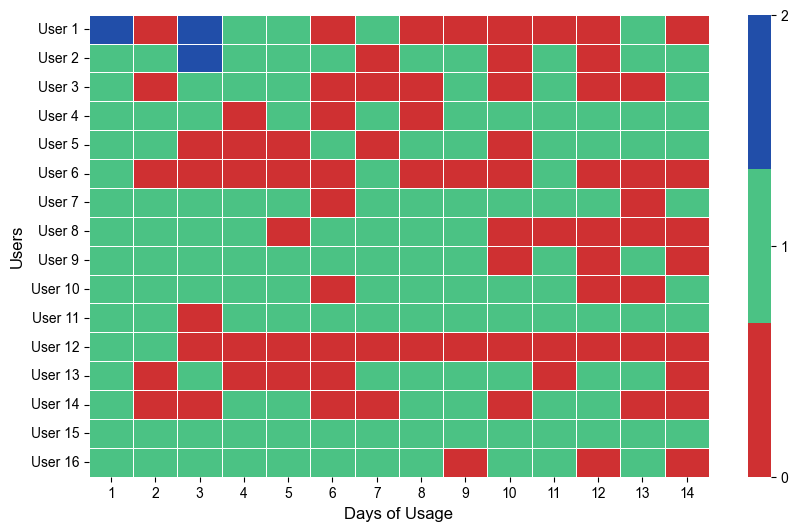

In [469]:
heatmap_data = valid_exercises.pivot_table(
    index='user_label',
    columns='day_of_usage',
    values='exerciseId',
    aggfunc='count',
    fill_value=0).sort_index()

cmap = sns.color_palette(["#CF3032","#4BC284","#214EA9"], 3)
custom_cmap = ListedColormap(cmap)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data, cmap=custom_cmap, linewidth=0.5, annot=False, cbar_kws={"ticks": [0,1,2]})


# Add labels
plt.xlabel("Days of Usage", fontsize=12)
plt.ylabel("Users", fontsize=12)
plt.show()

In [ ]:
heatmap_data

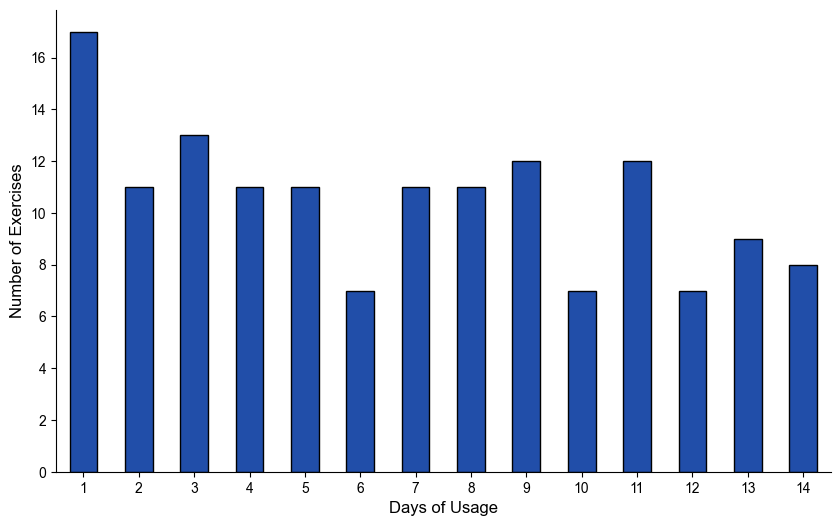

In [491]:
total_exercises_per_user = valid_exercises.groupby('day_of_usage')['exerciseId'].count()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

plt.figure(figsize=(10, 6))
total_exercises_per_user.plot(kind='bar', color='#214EA9', edgecolor='black')

plt.xlabel("Days of Usage", fontsize=12)
plt.ylabel("Number of Exercises", fontsize=12)

plt.xticks(rotation=0)
plt.show()

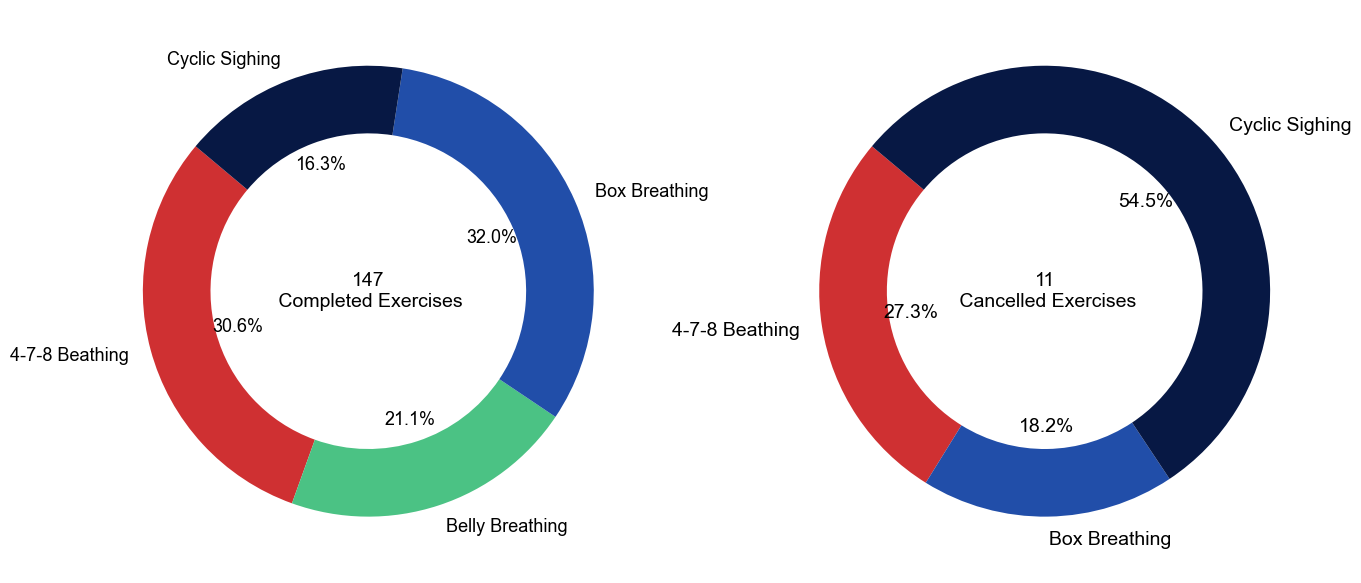

In [608]:
exercise_counts = valid_exercises['exerciseNamePretty'].value_counts().sort_index()
cancelled_counts = cancelled_exercises_df[cancelled_exercises_df['event'] == 'cancelled']['exerciseNamePretty'].value_counts().sort_index()

custom_colors_four = ["#CF3032","#4BC284","#214EA9", "#071844"]
custom_colors_three = ["#CF3032","#214EA9", "#071844"]
plt.rcParams['font.family'] = 'Arial'

figure, axis = plt.subplots(1, 2, figsize=(16, 8))
axis[0].pie(
    exercise_counts, 
    labels=exercise_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'width': 0.3},
    colors=custom_colors_four,
    textprops={'fontsize': 13}
)
total_count = exercise_counts.sum()
axis[0].text(0, 0, f'{total_count}\n Completed Exercises', ha='center', va='center', fontsize=14, fontweight='regular')

axis[1].pie(
    cancelled_counts, 
    labels=cancelled_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops={'width': 0.3},
    colors=custom_colors_three,
    textprops={'fontsize': 14}
)
cancelled_count = cancelled_counts.sum()
axis[1].text(0, 0, f'{cancelled_count}\n Cancelled Exercises', ha='center', va='center', fontsize=14, fontweight='regular')

plt.show()

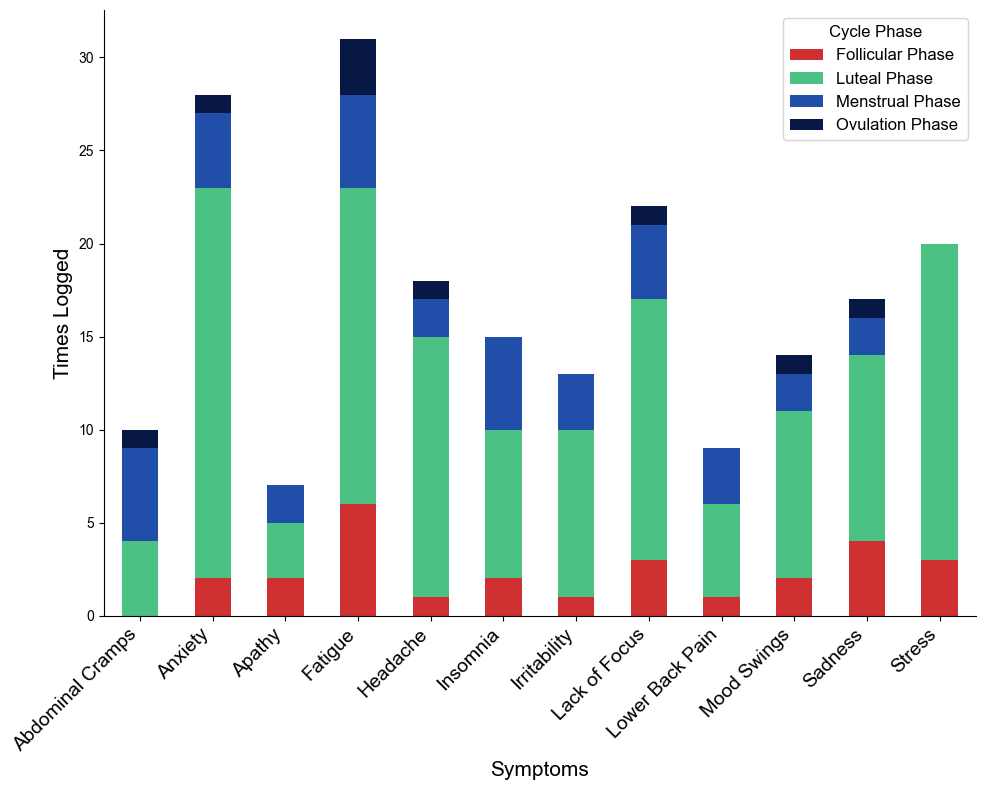

In [526]:
grouped_data = valid_symptoms.groupby(['name', 'cyclePhase']).size().unstack(fill_value=0)

cmap = sns.color_palette(["#CF3032","#4BC284","#214EA9","#071844"], 4)
custom_cmap = ListedColormap(cmap)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

grouped_data.plot(kind='bar', stacked=True, figsize=(10, 8), colormap=custom_cmap)

plt.xlabel('Symptoms', fontsize="15")
plt.ylabel('Times Logged', fontsize="15")
plt.xticks(fontsize="14")
plt.legend(title='Cycle Phase', loc='upper right', title_fontsize=12, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

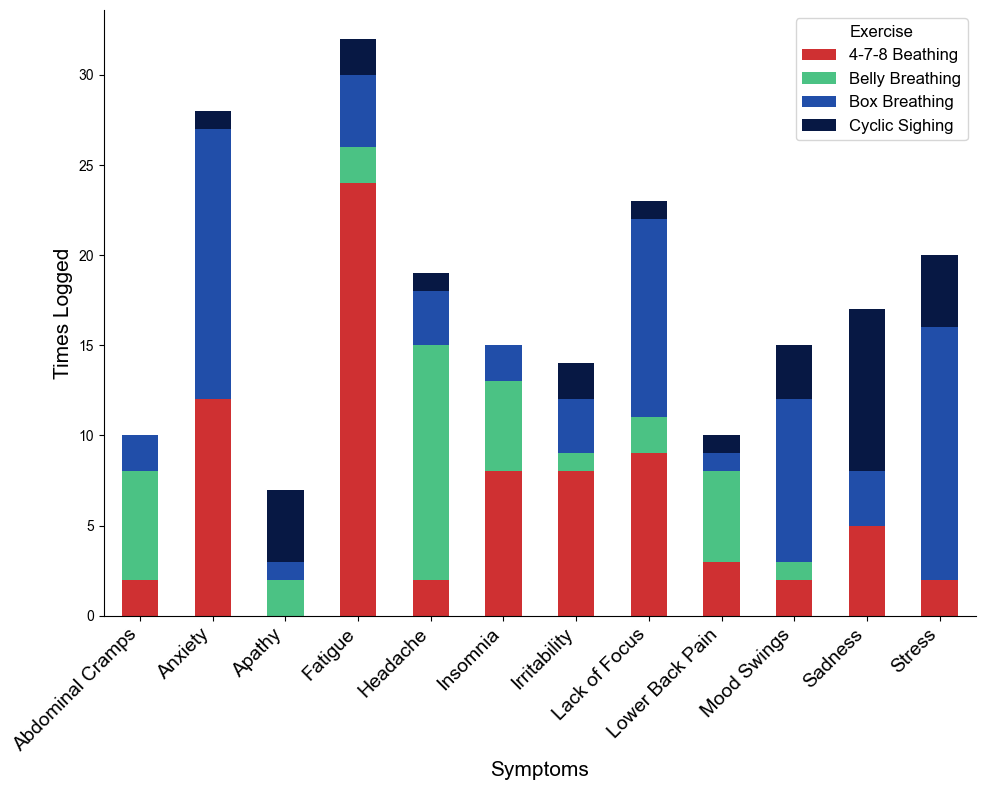

In [570]:
grouped_data = valid_symptoms.groupby(['name', 'exerciseNamePretty']).size().unstack(fill_value=0)

cmap = sns.color_palette(["#CF3032","#4BC284","#214EA9","#071844"], 4)
custom_cmap = ListedColormap(cmap)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

grouped_data.plot(kind='bar', stacked=True, figsize=(10, 8), colormap=custom_cmap)

plt.xlabel('Symptoms', fontsize="15")
plt.ylabel('Times Logged', fontsize="15")
plt.xticks(fontsize="14")
plt.legend(title='Exercise', loc='upper right', title_fontsize=12, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [ ]:
aggregated_data = valid_symptoms.groupby('name')[['intensityBefore', 'intensityAfter']].mean().reset_index()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

aggregated_data.set_index('name', inplace=True)

cmap = sns.color_palette(["#4BC284","#071844"], 2)
custom_cmap = ListedColormap(cmap)

aggregated_data.plot(kind='bar', figsize=(12, 6.9), cmap=custom_cmap)

plt.ylabel('Average Intensity')
plt.xlabel('Symptoms')
plt.legend(labels=["Intensity Before Exercise", "Intensity After Exercise"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [609]:
def get_data_for_boxplots(dataframe):
    cramps = dataframe[dataframe['name']=="Abdominal Cramps"]
    anxiety = dataframe[dataframe['name']=="Anxiety"]
    apathy = dataframe[dataframe['name']=="Apathy"]
    fatigue = dataframe[dataframe['name']=="Fatigue"]
    headache = dataframe[dataframe['name']=="Headache"]
    insomnia = dataframe[dataframe['name']=="Insomnia"]
    irritability = dataframe[dataframe['name']=="Irritability"]
    focus = dataframe[dataframe['name']=="Lack of Focus"]
    back = dataframe[dataframe['name']=="Lower Back Pain"]
    mood = dataframe[dataframe['name']=="Mood Swings"]
    sadness = dataframe[dataframe['name']=="Sadness"]
    stress = dataframe[dataframe['name']=="Stress"]
    return [
    cramps['Improvement (%)'], 
    anxiety['Improvement (%)'],
    apathy['Improvement (%)'],
    fatigue['Improvement (%)'],
    headache['Improvement (%)'],
    insomnia['Improvement (%)'],
    irritability['Improvement (%)'],
    focus['Improvement (%)'],
    back['Improvement (%)'],
    mood['Improvement (%)'],
    sadness['Improvement (%)'],
    stress['Improvement (%)'],
    ]

name
Abdominal Cramps    24.046512
Anxiety             27.527151
Apathy              14.754098
Fatigue             16.421569
Headache            15.384615
Insomnia             0.000000
Irritability        13.913978
Lack of Focus       17.647059
Lower Back Pain     15.537634
Mood Swings         14.285714
Sadness             10.526316
Stress              18.151996
Name: Improvement (%), dtype: float64


/var/folders/w1/3kk57lj561xdpf_0kz_gbd240000gp/T/ipykernel_17301/4145100229.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(get_data_for_boxplots(valid_symptoms), labels=symptom_labels,


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(1, 0, 'Abdominal Cramps'),
  Text(2, 0, 'Anxiety'),
  Text(3, 0, 'Apathy'),
  Text(4, 0, 'Fatigue'),
  Text(5, 0, 'Headache'),
  Text(6, 0, 'Insomnia'),
  Text(7, 0, 'Irritability'),
  Text(8, 0, 'Lack of Focus'),
  Text(9, 0, 'Lower Back Pain'),
  Text(10, 0, 'Mood Swings'),
  Text(11, 0, 'Sadness'),
  Text(12, 0, 'Stress')])

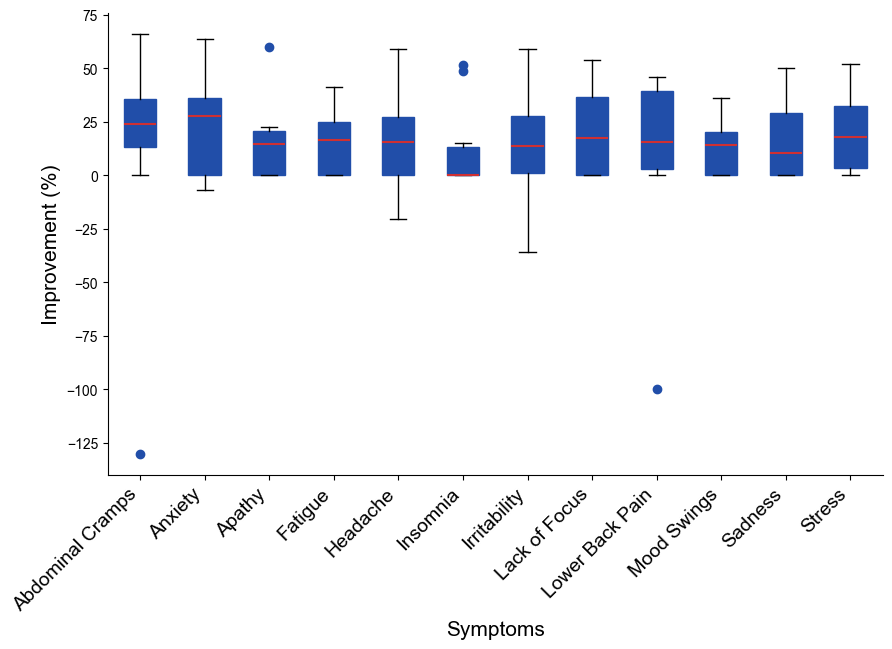

In [617]:
valid_symptoms['Improvement (units)'] = valid_symptoms['intensityBefore'] - valid_symptoms['intensityAfter']

valid_symptoms['Improvement (%)'] = valid_symptoms.apply(
    lambda row: ((row['intensityBefore'] - row['intensityAfter']) / row['intensityBefore'] * 100)
    if row['intensityBefore'] != 0 else 0, axis=1
)

symptom_labels=['Abdominal Cramps','Anxiety','Apathy','Fatigue','Headache','Insomnia','Irritability', 'Lack of Focus','Lower Back Pain','Mood Swings','Sadness','Stress']


print(valid_symptoms.groupby('name')['Improvement (%)'].median())

plt.figure(figsize=(10, 6))
plt.xticks(rotation=45, ha='right')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

plt.boxplot(get_data_for_boxplots(valid_symptoms), labels=symptom_labels, 
    patch_artist=True,
    boxprops=dict(facecolor="#214EA9", color="#214EA9"),
    flierprops=dict(markerfacecolor="#214EA9", markeredgecolor="#214EA9",),
    medianprops=dict(color="#CF3032", linewidth=1.5))

plt.ylabel('Improvement (%)', fontsize="15")
plt.xlabel('Symptoms', fontsize="15")
plt.xticks(fontsize="14")

In [618]:
print(valid_symptoms[valid_symptoms['name']=='Insomnia']['Improvement (%)'])

65      0.000000
75     15.151515
88     12.698413
96      0.000000
97      0.000000
102    51.428571
113    48.529412
114    13.513514
141     0.000000
162     0.000000
174     0.000000
182     0.000000
186     0.000000
213     0.000000
225     0.000000
Name: Improvement (%), dtype: float64


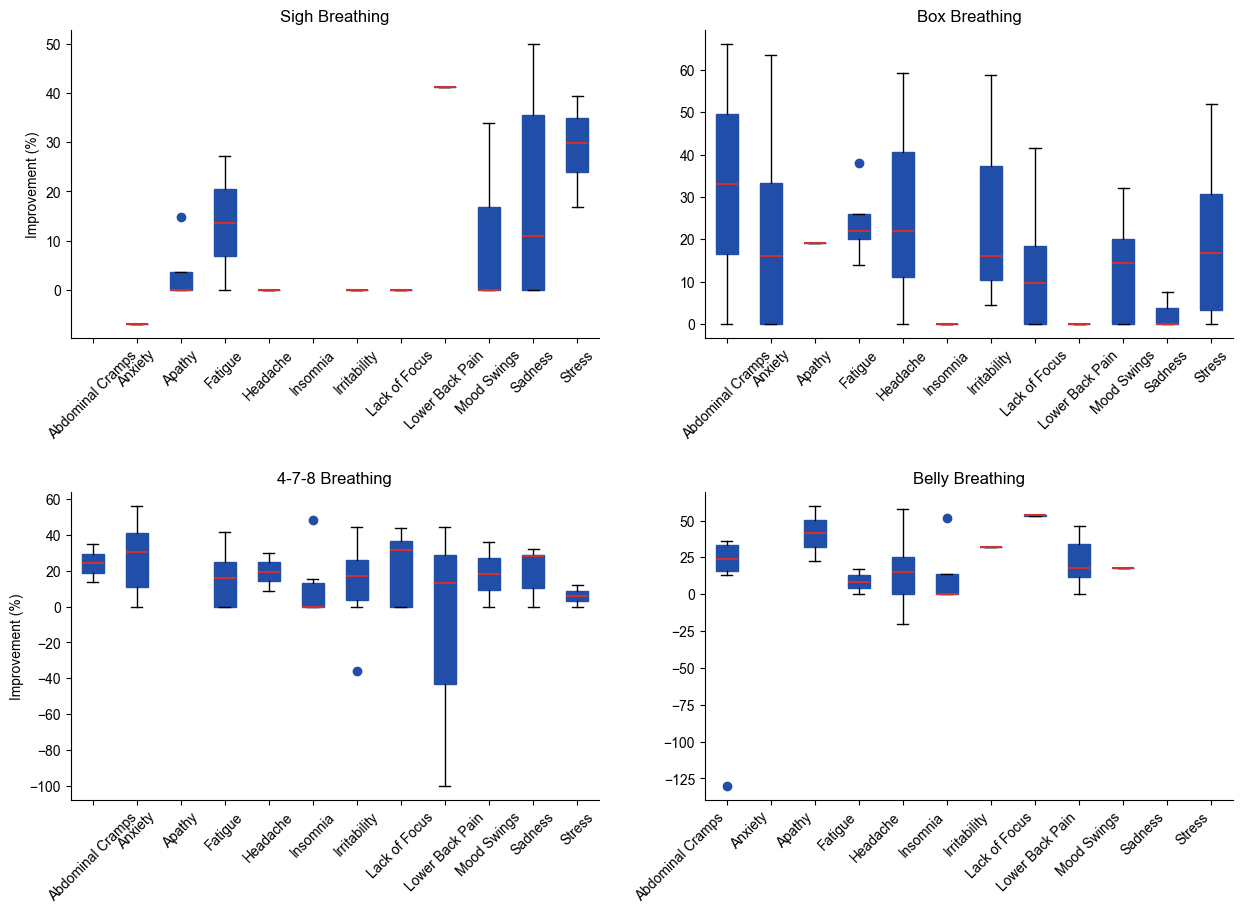

In [567]:
figure, axis = plt.subplots(2, 2, figsize=(15, 10))
plt.xticks(rotation=45, ha='right')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True


axis[0, 0].boxplot(get_data_for_boxplots(valid_symptoms[valid_symptoms['exercise'] == 'sigh']),
    patch_artist=True,
    boxprops=dict(facecolor="#214EA9", color="#214EA9"),
    flierprops=dict(markerfacecolor="#214EA9", markeredgecolor="#214EA9",),
    medianprops=dict(color="#CF3032", linewidth=1.5))
axis[0, 0].set_title("Sigh Breathing")
axis[0, 0].set_xticklabels(labels=symptom_labels, rotation=45)
axis[0, 0].set_ylabel("Improvement (%)")

axis[0, 1].boxplot(get_data_for_boxplots(valid_symptoms[valid_symptoms['exercise'] == 'box']),
    patch_artist=True,
    boxprops=dict(facecolor="#214EA9", color="#214EA9"),
    flierprops=dict(markerfacecolor="#214EA9", markeredgecolor="#214EA9",),
    medianprops=dict(color="#CF3032", linewidth=1.5))
axis[0, 1].set_title("Box Breathing")
axis[0, 1].set_xticklabels(labels=symptom_labels, rotation=45)

axis[1, 0].boxplot(get_data_for_boxplots(valid_symptoms[valid_symptoms['exercise'] == '478']),
    patch_artist=True,
    boxprops=dict(facecolor="#214EA9", color="#214EA9"),
    flierprops=dict(markerfacecolor="#214EA9", markeredgecolor="#214EA9",),
    medianprops=dict(color="#CF3032", linewidth=1.5))
axis[1, 0].set_title("4-7-8 Breathing")
axis[1, 0].set_xticklabels(labels=symptom_labels, rotation=45)
axis[1, 0].set_ylabel("Improvement (%)")

axis[1, 1].boxplot(get_data_for_boxplots(valid_symptoms[valid_symptoms['exercise'] == 'belly']),
    patch_artist=True,
    boxprops=dict(facecolor="#214EA9", color="#214EA9"),
    flierprops=dict(markerfacecolor="#214EA9", markeredgecolor="#214EA9",),
    medianprops=dict(color="#CF3032", linewidth=1.5))
axis[1, 1].set_title("Belly Breathing")
axis[1, 1].set_xticklabels(labels=symptom_labels, rotation=45)

figure.subplots_adjust(hspace=0.5)

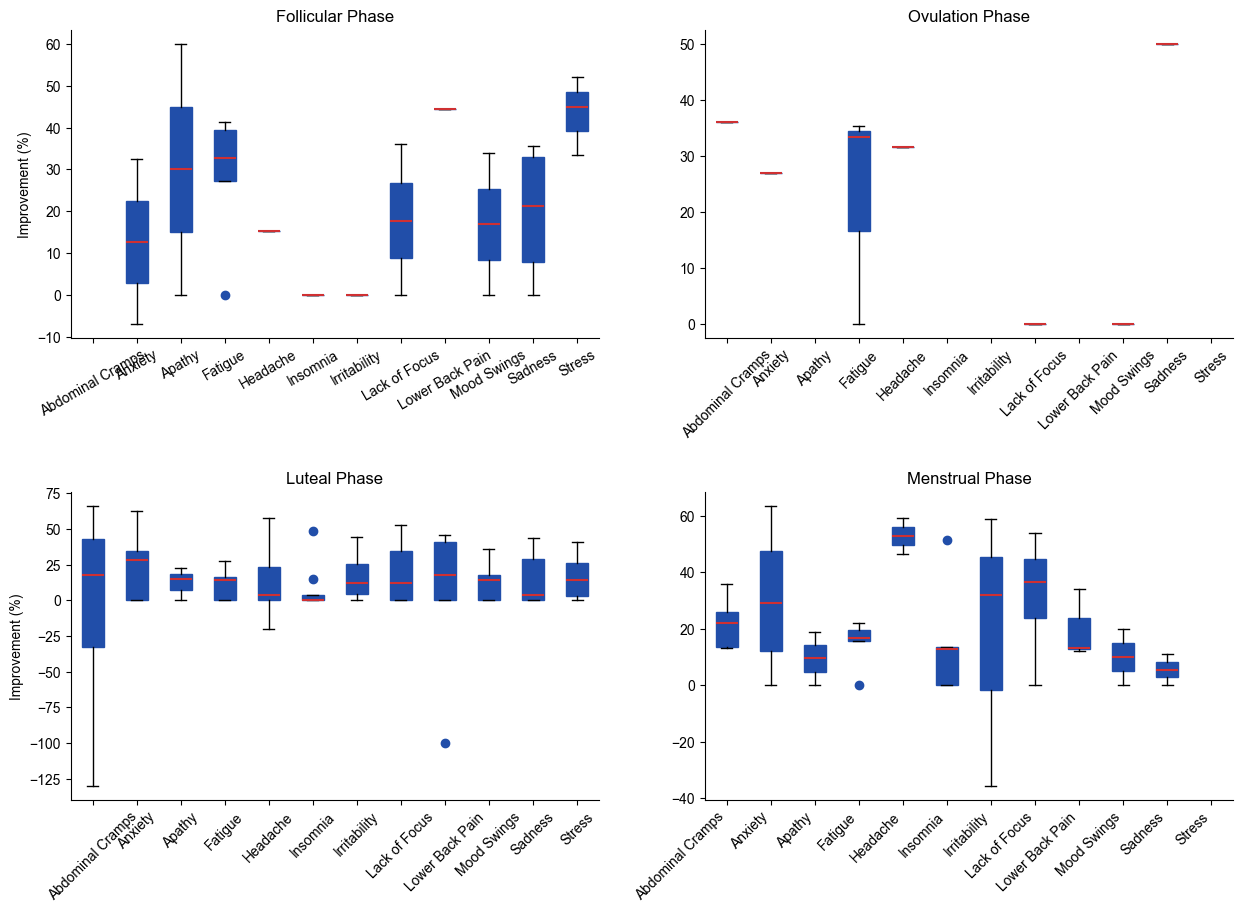

In [571]:
figure, axis = plt.subplots(2, 2, figsize=(15, 10))
plt.xticks(rotation=45, ha='right')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True


axis[0, 0].boxplot(get_data_for_boxplots(valid_symptoms[valid_symptoms['cyclePhase'] == 'Follicular Phase']),
    patch_artist=True,
    boxprops=dict(facecolor="#214EA9", color="#214EA9"),
    flierprops=dict(markerfacecolor="#214EA9", markeredgecolor="#214EA9",),
    medianprops=dict(color="#CF3032", linewidth=1.5))
axis[0, 0].set_title("Follicular Phase")
axis[0, 0].set_xticklabels(labels=symptom_labels, rotation=45)
axis[0, 0].set_ylabel("Improvement (%)")

axis[0, 1].boxplot(get_data_for_boxplots(valid_symptoms[valid_symptoms['cyclePhase'] == 'Ovulation Phase']),
    patch_artist=True,
    boxprops=dict(facecolor="#214EA9", color="#214EA9"),
    flierprops=dict(markerfacecolor="#214EA9", markeredgecolor="#214EA9",),
    medianprops=dict(color="#CF3032", linewidth=1.5))
axis[0, 1].set_title("Ovulation Phase")
axis[0, 1].set_xticklabels(labels=symptom_labels, rotation=45)

axis[1, 0].boxplot(get_data_for_boxplots(valid_symptoms[valid_symptoms['cyclePhase'] == 'Luteal Phase']),
    patch_artist=True,
    boxprops=dict(facecolor="#214EA9", color="#214EA9"),
    flierprops=dict(markerfacecolor="#214EA9", markeredgecolor="#214EA9",),
    medianprops=dict(color="#CF3032", linewidth=1.5))
axis[1, 0].set_title("Luteal Phase")
axis[1, 0].set_xticklabels(labels=symptom_labels, rotation=45)
axis[1, 0].set_ylabel("Improvement (%)")

axis[1, 1].boxplot(get_data_for_boxplots(valid_symptoms[valid_symptoms['cyclePhase'] == 'Menstrual Phase']),
    patch_artist=True,
    boxprops=dict(facecolor="#214EA9", color="#214EA9"),
    flierprops=dict(markerfacecolor="#214EA9", markeredgecolor="#214EA9",),
    medianprops=dict(color="#CF3032", linewidth=1.5))
axis[1, 1].set_title("Menstrual Phase")
axis[1, 1].set_xticklabels(labels=symptom_labels, rotation=45)

figure.subplots_adjust(hspace=0.5)